In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from game_environments.breakthrough.breakthrough import BTBoard, config as BTconfig
import random
from tqdm import tqdm
from PIL import Image
import ast
from itertools import permutations
from monte_carlo.mcts import MCTS
from monte_carlo.mctsnode import Node
import torch
import torch.optim as optim
import numpy as np
from game_environments.breakthrough.breakthrough import BTBoard,config
from neural_networks.breakthrough.breakthrough_nn import BreakthroughNN
import matplotlib as mpl
mpl.style.use('seaborn')

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}
selected_game = GAME["breakthrough"]
initial_state = selected_game.initial_state()

primary_nn = BreakthroughNN(initial_state.rows, initial_state.cols, initial_state.get_move_amount())
primary_nn.loadmodel('./trained_models', 'session_res10_gen_70.tar')

GAME = {
    "breakthrough": BTBoard(np.zeros([6,6]), 1),
}

selected_game = GAME["breakthrough"]
initial_state = Node(selected_game.initial_state(),"START")

seen_states = {}

frontier = [initial_state]

generate_new_data = False
new_data_size = 20000
dfs = False
monte_tree = MCTS()

NEURAL_NETWORK_THINK = 20

if generate_new_data:
    df = pd.DataFrame(columns=["id",
                               "player",
                               "state",
                               "terminal", 
                               "player_piece_amount", 
                               "piece_difference", 
                               "furthest_piece", 
                               "furthest_piece_difference",
                               "average_distance",
                               "lorentz_horey",
                               "lorentz_horey_difference"], 
                      dtype=np.int64
                      )
    state_id = 0
    
    while state_id < new_data_size:
        print("pre-game:",state_id ,"left:",new_data_size-state_id)
        curr_node = initial_state
        while not curr_node.gamestate.is_terminal():
            pi = monte_tree.get_policy(curr_node,NEURAL_NETWORK_THINK, primary_nn, 1)
            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi)

            working_state = curr_node.gamestate

            if not working_state.__hash__() in seen_states:
                heuristics = working_state.get_heuristics()
                df = df.append({
                    'id':state_id,
                    'state':working_state.encode_state(),
                    'player':working_state.player,
                    'terminal':working_state.is_terminal(),
                    'player_piece_amount':heuristics[0][1],
                    'piece_difference':heuristics[1][1],
                    'furthest_piece':heuristics[2][1],
                    'furthest_piece_difference':heuristics[3][1],
                    'average_distance':heuristics[4][1],
                    'lorentz_horey':heuristics[5][1],
                    'lorentz_horey_difference':heuristics[6][1]
                },ignore_index=True)
                seen_states[working_state.__hash__()] = True
                state_id += 1

            curr_node = np.random.choice(curr_node.children, p=pi)
        working_state = curr_node.gamestate
        if not working_state.__hash__() in seen_states:
            heuristics = working_state.get_heuristics()
            df = df.append({
                'id':state_id,
                'state':working_state.encode_state(),
                'player':working_state.player,
                'terminal':working_state.is_terminal(),
                'player_piece_amount':heuristics[0][1],
                'piece_difference':heuristics[1][1],
                'furthest_piece':heuristics[2][1],
                'furthest_piece_difference':heuristics[3][1],
                'average_distance':heuristics[4][1],
                'lorentz_horey':heuristics[5][1],
                'lorentz_horey_difference':heuristics[6][1]
            },ignore_index=True)
            seen_states[working_state.__hash__()] = True
            state_id += 1
        
    df.set_index('id') 

    df.to_csv(f'./mcts_moves_heuristic_{new_data_size}_think_{NEURAL_NETWORK_THINK}.csv')
else:
    df = pd.read_csv(f'./mcts_moves_heuristic_{new_data_size}_think_{NEURAL_NETWORK_THINK}.csv', converters={'state': from_np_array}).set_index('id')


plt.imshow(df.iloc[0,2]*np.array([1,1,0]))
plt.show()
tdf = df[df['terminal'] == True]
for i,row in tdf.iterrows():
    plt.imshow(row['state'] * np.array([1,1,0]))
    plt.show()

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 1. 0.]
  [1. 1. 1. 1. 1. 1.]]

 [[1. 1. 0. 0. 0. 1.]
  [0. 1. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]
-1.3333333333333333 and white


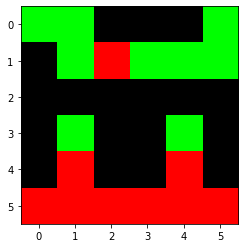

In [3]:
df.average_distance.describe()
for i ,row in df[df.average_distance == df.average_distance.min()].sample(1).iterrows():
    img = row.state
    img[2,:,:] = 0
    print(row.state)
    print(f"{row.average_distance} and {'white' if row.player == -1 else 'black'}")
    plt.imshow(img.transpose(1,2,0))
    plt.show()


In [5]:
print(len(df[df.average_distance == df.average_distance.max()]))
print(df.average_distance.min())
df.average_distance = df.average_distance.abs()
print(df.average_distance.describe())

3
-1.3
count    20013.000000
mean         0.447460
std          0.261033
min          0.000000
25%          0.250000
50%          0.409091
75%          0.600000
max          1.300000
Name: average_distance, dtype: float64


In [6]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


class StateDataset(Dataset):
    def __init__(self, _x, _y):
        self.X = _x.copy()
        self.y = _y.copy()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X.iloc[idx], self.y.iloc[idx]



# X = df['state']
# y = df['piece_difference']


# stateDS = StateDataset(X,y)
import time
from IPython.display import clear_output


piece_diff_positive = df[df['piece_difference'] >= 2].sample(1000)
piece_diff_random = df[df['piece_difference'] < 2].sample(1000)
piece_diff_tcav_df = pd.concat([piece_diff_positive, piece_diff_random])
piece_diff_X = piece_diff_tcav_df['state']
piece_diff_y = piece_diff_tcav_df['piece_difference']
piece_diff_DS = StateDataset(piece_diff_X,piece_diff_y)
piece_diff_DL = DataLoader(piece_diff_DS, shuffle=True, batch_size=1)

all_piece_diff_X = df['state']
all_piece_diff_y = df['piece_difference']
all_piece_diff_DS = StateDataset(all_piece_diff_X, all_piece_diff_y)
all_piece_diff_DL = DataLoader(all_piece_diff_DS, shuffle=True, batch_size=1)

aggro_positive = df[df['furthest_piece_difference'] >= 1].sample(2500)
aggro_random = df[df['furthest_piece_difference'] < 1].sample(2500)
aggro_diff_tcav_df = pd.concat([aggro_positive, aggro_random])
aggro_diff_X = aggro_diff_tcav_df['state']
aggro_diff_y = aggro_diff_tcav_df['furthest_piece_difference']
aggro_diff_DS = StateDataset(aggro_diff_X, aggro_diff_y)
aggro_diff_DL = DataLoader(aggro_diff_DS, shuffle=True, batch_size=1)

all_aggro_diff_X = df['state']
all_aggro_diff_y = df['furthest_piece_difference']
all_aggro_diff_DS = StateDataset(all_aggro_diff_X,all_aggro_diff_y)
all_aggro_diff_DL = DataLoader(all_aggro_diff_DS, shuffle=True, batch_size=1)

avg_dist_positive = df[df['average_distance'] < 0.35].sample(2500)
avg_dist_random = df[df['average_distance'] >= 0.35].sample(2500)
avg_dist_tcav_df = pd.concat([avg_dist_positive, avg_dist_random])
avg_dist_X = avg_dist_tcav_df['state']
avg_dist_y = avg_dist_tcav_df['average_distance']
avg_dist_DS = StateDataset(avg_dist_X,avg_dist_y)
avg_dist_DL = DataLoader(avg_dist_DS, shuffle=True, batch_size=1)

all_avg_dist_X = df['state']
all_avg_dist_y = df['average_distance']
all_avg_dist_DS = StateDataset(all_avg_dist_X,all_avg_dist_y)
all_avg_dist_DL = DataLoader(all_avg_dist_DS, shuffle=True, batch_size=1)

lorentz_diff_positive = df[df['lorentz_horey_difference'] >= 5].sample(2500)
lorentz_diff_negative = df[df['lorentz_horey_difference'] < 5].sample(2500)
lorentz_diff_tcav_df = pd.concat([lorentz_diff_positive, lorentz_diff_negative])
lorentz_diff_X = lorentz_diff_tcav_df['state']
lorentz_diff_y = lorentz_diff_tcav_df['lorentz_horey_difference']
lorentz_diff_DS = StateDataset(lorentz_diff_X,lorentz_diff_y)
lorentz_diff_DL = DataLoader(lorentz_diff_DS, shuffle=True, batch_size=1)


In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

concept_list = []
activations_list = []
target_list = []

outputs = []

for batch_idx, (data, target) in enumerate(aggro_diff_DL):
    data.to(device), target.to(device)
    
    activations = net.forward_0(data.float())
    activations_list.append(activations.clone().detach().cpu())
    concept_list.append(target.item() >= 1)
    outputs.append(net.forward_1(activations))

NameError: name 'aggro_diff_DL' is not defined

In [23]:
lm = LogisticRegression(max_iter=1000)
lm = LinearRegression()
lm = SGDClassifier(max_iter=10000)



tcav_x = [act.flatten().numpy() for act in activations_list]
tcav_y = concept_list

tcav_x_train, tcav_x_test, tcav_y_train, tcav_y_test = train_test_split(tcav_x, tcav_y, test_size=0.33)

lm.fit(tcav_x_train, tcav_y_train)
y_pred = lm.predict(tcav_x_test)

roc_auc = roc_auc_score(tcav_y_test, y_pred)

CAV = lm.coef_

print("ROC AUC score:", roc_auc)
print("CAV:",CAV)

ROC AUC score: 0.7049542094229284
CAV: [[-4.11148806  1.09473055  2.84327389 ... -0.531295   -2.70845602
  -1.82728432]]


In [24]:
scores = []
flat_cav = CAV.flatten()
counter = 0

corrolated_white = 0
w_white_above_pos = 0
w_white_above_neg = 0
w_black_above_pos = 0
w_black_above_neg = 0
w_equal_pos = 0
w_equal_neg = 0
b_white_above_pos = 0
b_white_above_neg = 0
b_black_above_pos = 0
b_black_above_neg = 0
b_equal_pos = 0
b_equal_neg = 0
amount = 0
highest_tcav_score = -1000000000
highest_data = None
action_taken = -1

white_count = 0
black_count = 0
white_counter = 0
black_counter = 0
white_tcav_sum = 0
black_tcav_sum = 0


for batch_idx, (data, target) in enumerate(all_piece_diff_DL):
    data.to(device), target.to(device)
    activations = net.forward_0(data.float())
    
    acts_var = torch.autograd.Variable(activations.clone().detach().to(device), requires_grad=True)
    outputs = net.forward_1(acts_var)
    
    # get the action we would take doing mcts
    #curr_node = Node(data)
    
    # get output we want the gradient wrt (move it picked or the score it gave)
    midx = torch.argmax(outputs[0]).item()
#     print(outputs[0])
#     print(outputs[0][0][midx])
#     for idx,k in enumerate(outputs[0]):
#         print(idx,k)
#     print(midx)
#     break

    # grad wrt value
#     grad = -torch.autograd.grad(outputs[1], acts_var)[0]
    
    # grad wrt highest action in policy vector
    grad = torch.autograd.grad(outputs[0][0][midx], acts_var)[0]
    
    tcav_score = np.dot(grad.detach().cpu().numpy().flatten(), flat_cav)
    white_count = data[0,0].sum().item()
    black_count = data[0,1].sum().item()
    player_white = data.detach().cpu().numpy()[0][2,0,0] == 1
    
    if player_white:
        if white_count > black_count and tcav_score < 0:
            w_white_above_neg += 1
        elif white_count < black_count and tcav_score < 0:
            w_black_above_neg += 1
        elif white_count > black_count and tcav_score > 0:
            w_white_above_pos += 1
        elif white_count < black_count and tcav_score > 0:
            w_black_above_pos += 1
        elif tcav_score < 0:
            w_equal_neg += 1
        else:
            w_equal_pos += 1
    if not player_white:
        if white_count > black_count and tcav_score < 0:
            b_white_above_neg += 1
        elif white_count < black_count and tcav_score < 0:
            b_black_above_neg += 1
        elif white_count > black_count and tcav_score > 0:
            b_white_above_pos += 1
        elif white_count < black_count and tcav_score > 0:
            b_black_above_pos += 1
        elif tcav_score < 0:
            b_equal_neg += 1
        else:
            b_equal_pos += 1
            
    if tcav_score > highest_tcav_score:
        highest_tcav_score = tcav_score
        highest_data = data
        action_taken = midx
    amount += 1
    
print("w w>b p", w_white_above_pos) 
print("w w>b n", w_white_above_neg) 
print("w w<b p", w_black_above_pos) 
print("w w<b n", w_black_above_neg) 
print("b w>b p", b_white_above_pos) 
print("b w>b n", b_white_above_neg) 
print("b w<b p", b_black_above_pos) 
print("b w<b n", b_black_above_neg) 
print("w e p",w_equal_pos)
print("w e n",w_equal_neg)

w w>b p 53
w w>b n 1215
w w<b p 58
w w<b n 1645
b w>b p 417
b w>b n 1157
b w<b p 316
b w<b n 988
w e p 90
w e n 1983


In [ ]:
#highest_data = highest_data.detach().cpu().numpy()
player = 1 if highest_data[0][2,0,0] == 0 else -1
print(to_bt_board)
to_bt_board = highest_data[2,:,:] * 0
print(to_bt_board)
to_bt_board += highest_data[1]
test = Node(BTBoard(to_bt_board,player),"START")
test.gamestate.print_board()
masked_highest_data = highest_data
masked_highest_data[2,:,:] = 0
# print(highest_data)
# print(masked_highest_data)

plt.imshow(masked_highest_data.transpose(1,2,0))

In [ ]:
highest_tcav_score

In [4]:
from game_environments.breakthrough.breakthrough import BTBoard
from monte_carlo.mcts import MCTS

dataset = []
NEURAL_NETWORK_THINK = 100
temp = 0


In [7]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
import copy

percentage = []
roc_auc_scores = []
gens = [10*k for k in range(0,8)]

for g in gens:
    print("doing gen ",g)
    
    game_example = BTBoard(np.zeros([6,6]),1)

    new_df = pd.DataFrame(columns=["id",
                               "player",
                               "state",
                               "terminal", 
                               "player_piece_amount", 
                               "piece_difference", 
                               "furthest_piece", 
                               "furthest_piece_difference",
                               "average_distance",
                               "lorentz_horey",
                               "lorentz_horey_difference"], 
                      dtype=np.int64
                      )


    monte_tree = MCTS()

    primary_nn = BreakthroughNN(game_example.rows, game_example.cols, game_example.get_move_amount())
    primary_nn.loadmodel('./trained_models', f'session_res10_gen{g}.tar')
    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    # HERE WE TRAIN A CAV

    concept_list = []
    activations_list = []
    target_list = []

    outputs = []

    for batch_idx, (data, target) in enumerate(avg_dist_DL):
        data.to(device), target.to(device)

        activations = primary_nn.forward_0(data.float())
        activations_list.append(activations.clone().detach().cpu())
        concept_list.append(target.item() < 0.35)
        outputs.append(primary_nn.forward_1(activations))
        
    
    lm = SGDClassifier(max_iter=10000)
    tcav_x = [act.flatten().numpy() for act in activations_list]
    tcav_y = concept_list
    tcav_x_train, tcav_x_test, tcav_y_train, tcav_y_test = train_test_split(tcav_x, tcav_y, test_size=0.33)
    lm.fit(tcav_x_train, tcav_y_train)
    y_pred = lm.predict(tcav_x_test)
    roc_auc = roc_auc_score(tcav_y_test, y_pred)
    CAV = lm.coef_
    print("ROC AUC score:", roc_auc)
    roc_auc_scores.append(roc_auc)
    
    flat_cav = CAV.flatten()
    # DONE CREATING THE CAV
    
    # HERE WE SIMULATE A GAME
    seen_states = set()
    state_id = 0
    
    game_lengths = []
    
    for i in range(100):
        curr_node = Node(game_example.initial_state(), "START")
        white_playing=True
        game_length = 0
        while not curr_node.gamestate.is_terminal():
            game_length += 1
#             pi = monte_tree.get_policy(curr_node,NEURAL_NETWORK_THINK, primary_nn, temp)

            pi,v = primary_nn.safe_predict(curr_node.gamestate)
            pi = pi.detach().cpu().numpy()[0]
            if not curr_node.is_expanded():
                curr_node.expand()
            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi)
            if white_playing:
                heuristics = curr_node.gamestate.get_heuristics()
                new_df = new_df.append({
                    'id':state_id,
                    'state':curr_node.gamestate.encode_state(),
                    'player':curr_node.gamestate.player,
                    'terminal':curr_node.gamestate.is_terminal(),
                    'player_piece_amount':heuristics[0][1],
                    'piece_difference':heuristics[1][1],
                    'furthest_piece':heuristics[2][1],
                    'furthest_piece_difference':heuristics[3][1],
                    'average_distance':heuristics[4][1],
                    'lorentz_horey':heuristics[5][1],
                    'lorentz_horey_difference':heuristics[6][1],
                },ignore_index=True)
                state_id += 1
            curr_node = np.random.choice(curr_node.children, p=pi)
            white_playing = not white_playing
        if white_playing:
            new_df = new_df.append({
                'id':state_id,
                'state':curr_node.gamestate.encode_state(),
                'player':curr_node.gamestate.player,
                'terminal':curr_node.gamestate.is_terminal(),
                'player_piece_amount':heuristics[0][1],
                'piece_difference':heuristics[1][1],
                'furthest_piece':heuristics[2][1],
                'furthest_piece_difference':heuristics[3][1],
                'average_distance':heuristics[4][1],
                'lorentz_horey':heuristics[5][1],
                'lorentz_horey_difference':heuristics[6][1],
            },ignore_index=True)
            state_id += 1
        game_lengths.append(game_length)
    new_df.set_index('id') 
    
    # DONE SIMULATING GAME
    
    # HERE WE EVALUATE THE TCAV SCORES
    
    new_df['tcav_score'] = 0
    count_has_hlc = 0
    for idx, row in new_df.iterrows():
        data = torch.FloatTensor(row.state)
        data.to(device)
        activations = primary_nn.forward_0(data.float())

        acts_var = torch.autograd.Variable(activations.clone().detach().to(device), requires_grad=True)
        outputs = primary_nn.forward_1(acts_var)

        # get output we want the gradient wrt (move it picked or the score it gave)
        midx = torch.argmax(outputs[0]).item()
    #     print(outputs[0])
    #     print(outputs[0][0][midx])
    #     for idx,k in enumerate(outputs[0]):
    #         print(idx,k)
    #     print(midx)
    #     break

        # grad wrt value
    #     grad = -torch.autograd.grad(outputs[1], acts_var)[0]

        # grad wrt highest action in policy vector
        grad = -torch.autograd.grad(outputs[0][0][midx], acts_var)[0]

        tcav_score = np.dot(grad.detach().cpu().numpy().flatten(), flat_cav)
        if tcav_score < 0:
            count_has_hlc += 1
        new_df.loc[idx,"tcav_score"] = tcav_score
    percentage.append(count_has_hlc/len(new_df))
    print("perc:",count_has_hlc/len(new_df))
    
avg_dist_percentage = copy.copy(percentage)
roc_auc_curve = copy.copy(roc_auc_scores)

doing gen  0
ROC AUC score: 0.8142218518959383
perc: 0.23045547246770903
doing gen  10
ROC AUC score: 0.8001102292768959
perc: 0.5578231292517006
doing gen  20
ROC AUC score: 0.7891786658830444
perc: 0.4993169398907104
doing gen  30
ROC AUC score: 0.7921310179559776
perc: 0.5306122448979592
doing gen  40
ROC AUC score: 0.8291016586323371
perc: 0.5972762645914397
doing gen  50
ROC AUC score: 0.7784391534391535
perc: 0.5377245508982036
doing gen  60
ROC AUC score: 0.7929348017828373
perc: 0.536283185840708
doing gen  70
ROC AUC score: 0.7852040036674817
perc: 0.4995507637017071


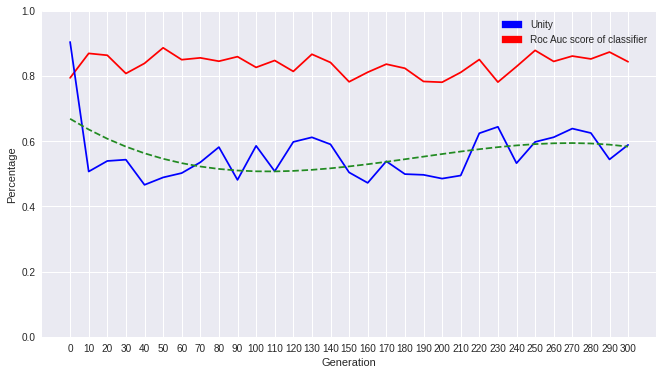

In [27]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(11,6))
ticks = np.arange(min(gens), max(gens)+1, 10)
plt.xticks(ticks)
plt.xlabel("Generation")
plt.ylabel("Percentage")
plt.ylim((0,1))

plt.plot(ticks,roc_auc_curve,'r')

# plt.plot(ticks,piece_diff_percentage, "b")
# plt.plot(ticks,aggro_diff_percentage, "b")
plt.plot(ticks,avg_dist_percentage, "b")
# plt.plot(ticks,lorentz_diff_percentage, "b")

# trendline1 = np.polyfit(ticks, piece_diff_percentage, 3)
# p1 = np.poly1d(trendline1)
# trendline2 = np.polyfit(ticks, aggro_diff_percentage, 3)
# p2 = np.poly1d(trendline2)
trendline3 = np.polyfit(ticks, avg_dist_percentage, 3)
p3 = np.poly1d(trendline3)
# trendline4 = np.polyfit(ticks, lorentz_diff_percentage, 3)
# p4 = np.poly1d(trendline4)
# plt.plot(ticks,p1(ticks), '--', color="forestgreen")
# plt.plot(ticks,p2(ticks),"--", color="forestgreen")
plt.plot(ticks,p3(ticks),"--", color="forestgreen")
# plt.plot(ticks,p4(ticks),"--", color="forestgreen")
patches = []
# patches.append(mpatches.Patch(color='b', label='Numbers advantage'))
# patches.append(mpatches.Patch(color='b', label='Aggressiveness'))
patches.append(mpatches.Patch(color='b', label='Unity'))
# patches.append(mpatches.Patch(color='b', label='Lorentz Horey'))
patches.append(mpatches.Patch(color='r', label='Roc Auc score of classifier'))
plt.legend(handles=patches)
plt.show()

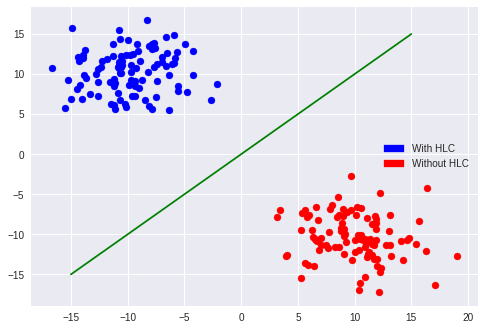

In [64]:
from random import random
import random

lpoints = [((10+((np.random.normal()*3))),-10+((np.random.normal()*3))) for _ in range(100)]
rpoints = [((-10+((np.random.normal()*3))),10+((np.random.normal()*3))) for _ in range(100)]

lx = [i[0] for i in lpoints]
ly = [i[1] for i in lpoints]
rx = [i[0] for i in rpoints]
ry = [i[1] for i in rpoints]
npatches = []
npatches.append(mpatches.Patch(color='b', label='With HLC'))
npatches.append(mpatches.Patch(color='r', label='Without HLC'))

plt.scatter(lx,ly,c="r")
plt.scatter(rx,ry,c="b")
plt.plot([-15,15],[-15,15],c='g')
# plt.arrow(0,0,-1,1,width=0.5,color="g")
plt.legend(handles=npatches)


(array([  31.,  168.,  684., 2314., 5230., 7662., 2927.,  810.,  159.,
          28.]),
 array([-64. , -51.8, -39.6, -27.4, -15.2,  -3. ,   9.2,  21.4,  33.6,
         45.8,  58. ]),
 <BarContainer object of 10 artists>)

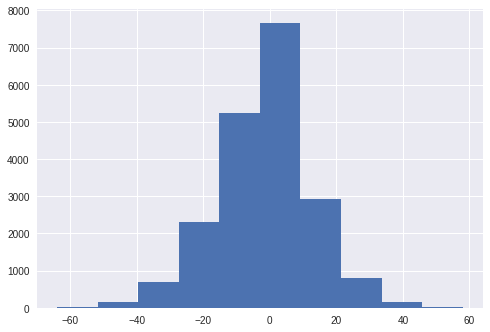

In [3]:
df.lorentz_horey_difference.describe()
plt.hist(df.lorentz_horey_difference)

In [9]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
import copy

percentage = []


game_example = BTBoard(np.zeros([6,6]),1)

new_df = pd.DataFrame(columns=["id",
                           "player",
                           "state",
                           "terminal", 
                           "player_piece_amount", 
                           "piece_difference", 
                           "furthest_piece", 
                           "furthest_piece_difference",
                           "average_distance",
                           "lorentz_horey",
                           "lorentz_horey_difference"], 
                  dtype=np.int64
                  )


monte_tree = MCTS()

primary_nn = BreakthroughNN(game_example.rows, game_example.cols, game_example.get_move_amount())
primary_nn.loadmodel('./trained_models', f'session2_res5_gen300.tar')


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# HERE WE SIMULATE A GAME
seen_states = set()
state_id = 0

game_lengths = []

for i in range(1000):
    curr_node = Node(game_example.initial_state(), "START")
    white_playing=True
    game_length = 0
    while not curr_node.gamestate.is_terminal():
        game_length += 1
        pi,v = primary_nn.safe_predict(curr_node.gamestate)
        pi = pi.detach().cpu().numpy()[0]
        if not curr_node.is_expanded():
            curr_node.expand()
        for i,child in enumerate(curr_node.children):
            if not child:
                pi[i] = 0
        pi = pi / sum(pi)
        heuristics = curr_node.gamestate.get_heuristics()
        new_df = new_df.append({
            'id':state_id,
            'state':curr_node.gamestate.encode_state(),
            'player':curr_node.gamestate.player,
            'terminal':curr_node.gamestate.is_terminal(),
            'player_piece_amount':heuristics[0][1],
            'piece_difference':heuristics[1][1],
            'furthest_piece':heuristics[2][1],
            'furthest_piece_difference':heuristics[3][1],
            'average_distance':heuristics[4][1],
            'lorentz_horey':heuristics[5][1],
            'lorentz_horey_difference':heuristics[6][1],
        },ignore_index=True)
        state_id += 1
        curr_node = np.random.choice(curr_node.children, p=pi)
        white_playing = not white_playing
    if white_playing:
        new_df = new_df.append({
            'id':state_id,
            'state':curr_node.gamestate.encode_state(),
            'player':curr_node.gamestate.player,
            'terminal':curr_node.gamestate.is_terminal(),
            'player_piece_amount':heuristics[0][1],
            'piece_difference':heuristics[1][1],
            'furthest_piece':heuristics[2][1],
            'furthest_piece_difference':heuristics[3][1],
            'average_distance':heuristics[4][1],
            'lorentz_horey':heuristics[5][1],
            'lorentz_horey_difference':heuristics[6][1],
        },ignore_index=True)
        state_id += 1
    game_lengths.append(game_length)
new_df.set_index('id') 

print(game_lengths)

[44, 25, 54, 45, 47, 34, 35, 26, 33, 57, 20, 48, 30, 24, 22, 50, 56, 46, 23, 45, 27, 44, 22, 54, 20, 31, 24, 37, 30, 42, 43, 18, 46, 59, 54, 52, 36, 34, 46, 55, 49, 53, 40, 18, 48, 20, 51, 20, 58, 26, 56, 38, 41, 34, 39, 55, 46, 25, 39, 38, 27, 25, 38, 32, 48, 19, 32, 34, 49, 39, 34, 28, 30, 48, 42, 20, 41, 20, 44, 47, 38, 21, 18, 31, 26, 23, 56, 49, 40, 34, 55, 49, 37, 22, 43, 38, 48, 47, 31, 46, 58, 41, 31, 51, 24, 20, 38, 41, 13, 14, 27, 51, 31, 58, 48, 52, 34, 36, 49, 54, 30, 40, 26, 20, 47, 20, 55, 20, 36, 27, 49, 24, 58, 49, 38, 47, 53, 43, 24, 34, 18, 40, 34, 55, 23, 34, 33, 31, 30, 47, 19, 31, 38, 45, 35, 36, 34, 51, 40, 45, 29, 39, 38, 26, 44, 47, 44, 39, 46, 40, 42, 40, 26, 24, 36, 46, 37, 25, 28, 24, 44, 47, 27, 21, 36, 28, 20, 28, 50, 26, 52, 36, 50, 32, 49, 22, 52, 33, 24, 46, 57, 35, 48, 50, 36, 35, 59, 39, 50, 30, 25, 36, 20, 33, 55, 53, 19, 39, 41, 43, 35, 51, 27, 43, 35, 55, 19, 38, 38, 55, 51, 51, 39, 30, 37, 38, 20, 55, 48, 29, 38, 30, 30, 39, 50, 44, 47, 47, 36, 49,

(array([  9.,  68., 109., 114., 138., 144., 144., 158.,  81.,  35.]),
 array([12., 17., 22., 27., 32., 37., 42., 47., 52., 57., 62.]),
 <BarContainer object of 10 artists>)

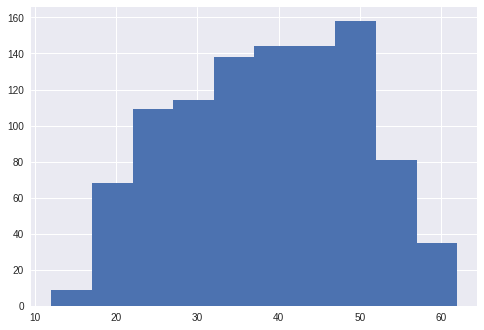

In [14]:
gl = np.array(game_lengths)
gl.mean()+gl.std()
plt.hist(gl)

In [26]:
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score
import copy

percentage = []
roc_auc_scores = []
gens = [10*k for k in range(0,31)]

for g in gens:
    print("doing gen ",g)
    
    game_example = BTBoard(np.zeros([6,6]),1)



    monte_tree = MCTS()

    primary_nn = BreakthroughNN(game_example.rows, game_example.cols, game_example.get_move_amount())
    primary_nn.loadmodel('./trained_models', f'session2_res5_gen{g}.tar')
    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    # HERE WE TRAIN A CAV

    concept_list = []
    activations_list = []
    target_list = []

    outputs = []

    for batch_idx, (data, target) in enumerate(aggro_diff_DL):
        data.to(device), target.to(device)

        activations = primary_nn.forward_0(data.float())
        activations_list.append(activations.clone().detach().cpu())
        concept_list.append(target.item() >= 1)
        outputs.append(primary_nn.forward_1(activations))
        
    
    lm = SGDClassifier(max_iter=10000)
    tcav_x = [act.flatten().numpy() for act in activations_list]
    tcav_y = concept_list
    tcav_x_train, tcav_x_test, tcav_y_train, tcav_y_test = train_test_split(tcav_x, tcav_y, test_size=0.33)
    lm.fit(tcav_x_train, tcav_y_train)
    y_pred = lm.predict(tcav_x_test)
    roc_auc = roc_auc_score(tcav_y_test, y_pred)
    CAV = lm.coef_
    print("ROC AUC score:", roc_auc)
    roc_auc_scores.append(roc_auc)
    
    flat_cav = CAV.flatten()
    # DONE CREATING THE CAV
    
    # HERE WE SIMULATE A GAME
    seen_states = set()
    state_id = 0
    
    game_lengths = []
    
    new_df = pd.DataFrame(columns=["id",
                               "player",
                               "state",
                               "terminal", 
                               "player_piece_amount", 
                               "piece_difference", 
                               "furthest_piece", 
                               "furthest_piece_difference",
                               "average_distance",
                               "lorentz_horey",
                               "lorentz_horey_difference",
                               "move_number"], 
                      dtype=np.int64
                      )
    
    for i in range(100):
        temp_df = pd.DataFrame(columns=["id",
                                   "player",
                                   "state",
                                   "terminal", 
                                   "player_piece_amount", 
                                   "piece_difference", 
                                   "furthest_piece", 
                                   "furthest_piece_difference",
                                   "average_distance",
                                   "lorentz_horey",
                                   "lorentz_horey_difference",
                                   "move_number"], 
                          dtype=np.int64
                          )
        curr_node = Node(game_example.initial_state(), "START")
        white_playing=True
        game_length = 0
        while not curr_node.gamestate.is_terminal():
            game_length += 1
#             pi = monte_tree.get_policy(curr_node,NEURAL_NETWORK_THINK, primary_nn, temp)

            pi,v = primary_nn.safe_predict(curr_node.gamestate)
            pi = pi.detach().cpu().numpy()[0]
            if not curr_node.is_expanded():
                curr_node.expand()
            for i,child in enumerate(curr_node.children):
                if not child:
                    pi[i] = 0
            pi = pi / sum(pi)
            if white_playing:
                heuristics = curr_node.gamestate.get_heuristics()
                temp_df = temp_df.append({
                    'id':state_id,
                    'state':curr_node.gamestate.encode_state(),
                    'player':curr_node.gamestate.player,
                    'terminal':curr_node.gamestate.is_terminal(),
                    'player_piece_amount':heuristics[0][1],
                    'piece_difference':heuristics[1][1],
                    'furthest_piece':heuristics[2][1],
                    'furthest_piece_difference':heuristics[3][1],
                    'average_distance':heuristics[4][1],
                    'lorentz_horey':heuristics[5][1],
                    'lorentz_horey_difference':heuristics[6][1],
                    'move_number':game_length
                },ignore_index=True)
                state_id += 1
            curr_node = np.random.choice(curr_node.children, p=pi)
            white_playing = not white_playing
        if white_playing:
            temp_df = temp_df.append({
                'id':state_id,
                'state':curr_node.gamestate.encode_state(),
                'player':curr_node.gamestate.player,
                'terminal':curr_node.gamestate.is_terminal(),
                'player_piece_amount':heuristics[0][1],
                'piece_difference':heuristics[1][1],
                'furthest_piece':heuristics[2][1],
                'furthest_piece_difference':heuristics[3][1],
                'average_distance':heuristics[4][1],
                'lorentz_horey':heuristics[5][1],
                'lorentz_horey_difference':heuristics[6][1],
                'move_number':game_length
            },ignore_index=True)
            state_id += 1
        new_df = new_df.append(temp_df.drop(temp_df[temp_df['move_number'] < game_length/2].index))
    new_df.set_index('id') 
    
    # DONE SIMULATING GAME
    
    # HERE WE EVALUATE THE TCAV SCORES
    
    new_df['tcav_score'] = 0
    count_has_hlc = 0
    for idx, row in new_df.iterrows():
        data = torch.FloatTensor(row.state)
        data.to(device)
        activations = primary_nn.forward_0(data.float())

        acts_var = torch.autograd.Variable(activations.clone().detach().to(device), requires_grad=True)
        outputs = primary_nn.forward_1(acts_var)

        # get output we want the gradient wrt (move it picked or the score it gave)
        midx = torch.argmax(outputs[0]).item()
    #     print(outputs[0])
    #     print(outputs[0][0][midx])
    #     for idx,k in enumerate(outputs[0]):
    #         print(idx,k)
    #     print(midx)
    #     break

        # grad wrt value
    #     grad = -torch.autograd.grad(outputs[1], acts_var)[0]

        # grad wrt highest action in policy vector
        grad = -torch.autograd.grad(outputs[0][0][midx], acts_var)[0]

        tcav_score = np.dot(grad.detach().cpu().numpy().flatten(), flat_cav)
        if tcav_score < 0:
            count_has_hlc += 1
        new_df.loc[idx,"tcav_score"] = tcav_score
    percentage.append(count_has_hlc/len(new_df))
    print("perc:",count_has_hlc/len(new_df))
    
avg_dist_percentage = copy.copy(percentage)
roc_auc_curve = copy.copy(roc_auc_scores)

doing gen  0
ROC AUC score: 0.7938447433032271
perc: 0.9040207522697795
doing gen  10
ROC AUC score: 0.868904051623823
perc: 0.5067024128686327
doing gen  20
ROC AUC score: 0.8631975313177327
perc: 0.5390625
doing gen  30
ROC AUC score: 0.8072777468414317
perc: 0.543040293040293
doing gen  40
ROC AUC score: 0.8383781448008361
perc: 0.4659400544959128
doing gen  50
ROC AUC score: 0.886085415736148
perc: 0.4885906040268456
doing gen  60
ROC AUC score: 0.8496085944662545
perc: 0.5019815059445178
doing gen  70
ROC AUC score: 0.8552425158900876
perc: 0.5349143610013175
doing gen  80
ROC AUC score: 0.8449078940984295
perc: 0.5815991237677984
doing gen  90
ROC AUC score: 0.8588817920947885
perc: 0.48108747044917255
doing gen  100
ROC AUC score: 0.8259867265933891
perc: 0.5854657113613101
doing gen  110
ROC AUC score: 0.8471485839906892
perc: 0.5075022065313327
doing gen  120
ROC AUC score: 0.8136966851811297
perc: 0.5974955277280859
doing gen  130
ROC AUC score: 0.8662937297221047
perc: 0.611